In [3]:
%load_ext autoreload
%autoreload 2

import os

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [2]:
from helper.synthesis import generate_pointwise_data

In [3]:
generate_pointwise_data()

100%|██████████| 60000/60000 [00:00<00:00, 227477.80it/s]


Data successfully generated!


<Axes: ylabel='Density'>

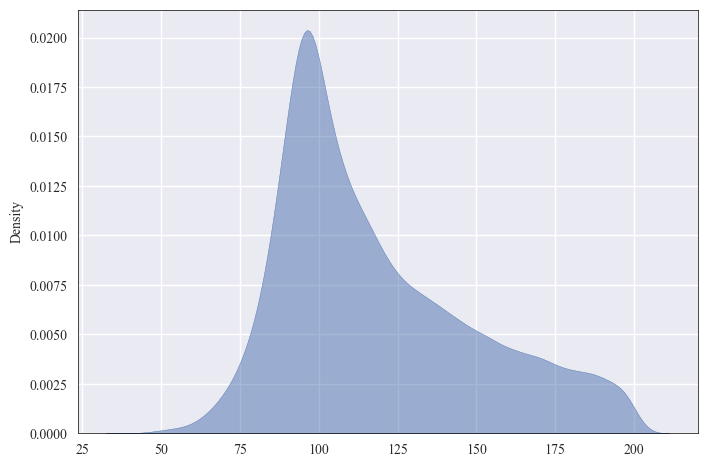

In [27]:
import seaborn as sns

from analysis.pointwise.utils import load_data

params_range_train, params_range_test, price_train, price_test = load_data()

sns.kdeplot(price_train, fill = True, alpha = 0.5)

<Axes: ylabel='Density'>

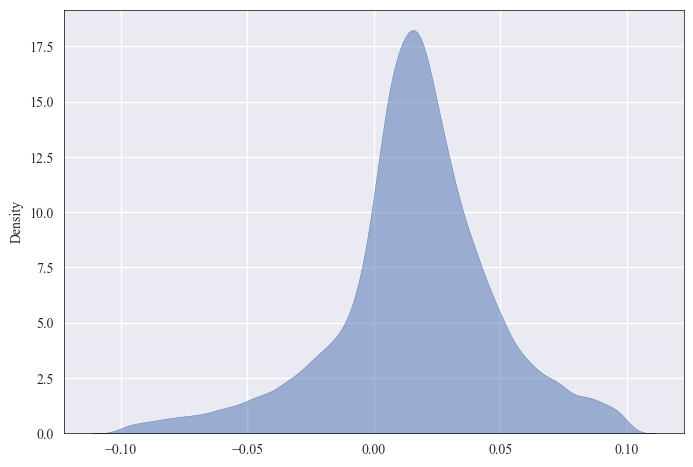

In [33]:
sns.kdeplot(params_range_train[:, 5], fill = True, alpha = 0.5)

In [15]:
import scipy

scipy.stats.describe(params_range_train[:, 5])

DescribeResult(nobs=41054, minmax=(-0.09997460298919944, 0.0999792785100099), mean=0.01598449554035423, variance=0.0010345298361706867, skewness=-0.4488075627220354, kurtosis=1.2321896035671873)

In [16]:
price_test.shape

(8409,)

In [17]:
params_range_test.shape

(8409, 6)

## Calibration

In [8]:
%load_ext autoreload
%autoreload 2

import os

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})


import tensorflow as tf
from analysis.pointwise.utils import init_model, load_data, load_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [9]:
model = init_model()
load_weights(model)
params_range_train, params_range_test, price_train, price_test = load_data()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  224       
                                                                 
 dense_1 (Dense)             multiple                  1056      
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
____________________________________________________

In [85]:
from scipy.optimize import Bounds

variable_bounds = {
        'a'    : [0.01, 0.20],
        'b'    : [1, 10],
        'sigma': [0.1, 1],
        'r'    : [0.00, 0.1]
        }

bounds = Bounds(
        [variable_bounds[key][0] for key in variable_bounds], [variable_bounds[key][1] for key in variable_bounds]
        )

from sklearn.metrics import mean_squared_error as mse

def objective_function(variable_input, fixed_input, model, y_true):

    y_pred = model(np.reshape(
            np.concatenate([fixed_input, variable_input])
            , newshape = (1, -1)))[0].numpy()

    return mse(y_true, y_pred)

import numpy as np
# objective_function([0.1, 5, 0.5, 0.05], [1, 0.04], model, np.array([100]))

In [88]:
import scipy

variable_input = params_range_test[0, 2:]
fixed_input = params_range_test[0, :2]
y_true = np.array([price_test[0]])
args = (fixed_input, model, y_true)
x0 = variable_input
s = scipy.optimize.minimize(
    objective_function, x0, method = 'trust-constr',
    options = {'verbose': 0}, bounds = bounds, args = args
    )

updated_variable_input = s.x

/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the ap

In [105]:
updated_variable_input = np.empty(shape = (1, 4))
for i in range(2):
    variable_input = params_range_test[i, 2:]
    fixed_input = params_range_test[i, :2]
    y_true = np.array([price_test[i]])
    args = (fixed_input, model, y_true)
    x0 = variable_input
    s = scipy.optimize.minimize(
        objective_function, x0, method = 'trust-constr',
        options = {'verbose': 0}, bounds = bounds, args = args
        )

    updated_variable_input = np.append(updated_variable_input, s.x.reshape((1, -1)), axis=0)

/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the ap

In [4]:
import warnings


warnings.filterwarnings("ignore")

In [116]:
from analysis.pointwise.model_calibration import calibrate_synthetic

2023-02-20 19:34:04,854 | INFO: | model_calibration.py | calibrate_synthetic | 74: Beginning calibration for model dense with vasicek


100%|██████████| 1000/1000 [31:10<00:00,  1.87s/it]

2023-02-20 20:05:15,795 | INFO: | model_calibration.py | calibrate_synthetic | 128: Calibration complete! change in parameters: 27.34166901962909
2023-02-20 20:05:15,801 | INFO: | model_calibration.py | calibrate_synthetic | 132: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek.dat


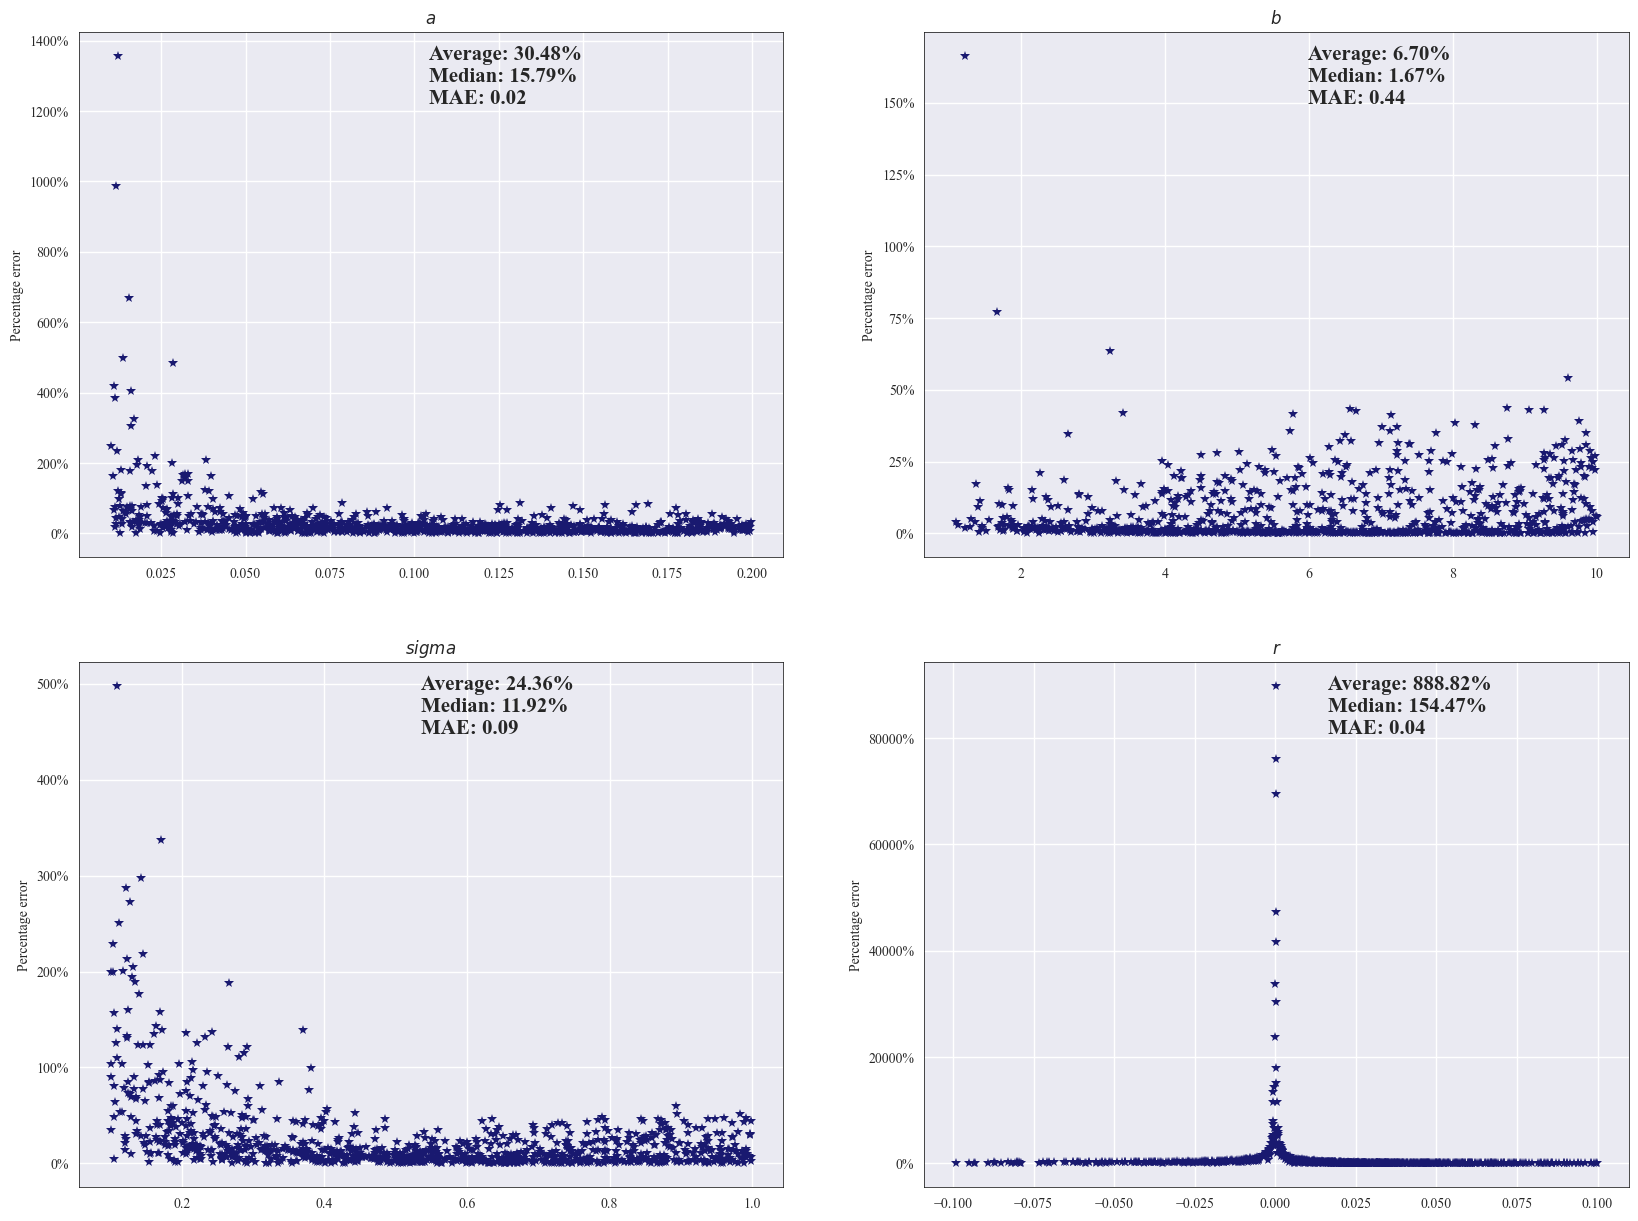

In [127]:
calibrate_synthetic(model, calibration_size = 1000)

In [26]:
import numpy as np
initial_parameters = np.array([0.1, 5, 0.3, 0.025 / 100], dtype = np.float64)

maturities = ['3M', '6M'] #, '1Y', '2Y', '3Y', '5Y', '10Y', '20Y', '30Y']

import pandas as pd
from analysis.pointwise.model_calibration import calibrate_to_market_data
for maturity in maturities:

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv')

    calibrate_to_market_data(
        model = model, market_data = df['Bond Price'], initial_parameters = initial_parameters,
        time_to_expiry = df['Time to Expiry'], coupon_rate = 0, maturity = maturity
        )

2023-02-24 16:24:54,380 | INFO: | model_calibration.py | calibrate_to_market_data | 189: Beginning calibration for model dense with vasicek for 3M maturity


100%|██████████| 302/302 [04:08<00:00,  1.21it/s]

2023-02-24 16:29:03,224 | INFO: | model_calibration.py | calibrate_to_market_data | 245: Calibration complete! change in parameters: 68.08910136795535
2023-02-24 16:29:03,227 | INFO: | model_calibration.py | calibrate_to_market_data | 252: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_3M.dat
2023-02-24 16:29:03,231 | INFO: | model_calibration.py | calibrate_to_market_data | 189: Beginning calibration for model dense with vasicek for 6M maturity



100%|██████████| 302/302 [01:58<00:00,  2.54it/s]

2023-02-24 16:31:01,987 | INFO: | model_calibration.py | calibrate_to_market_data | 245: Calibration complete! change in parameters: 58.51192782297018
2023-02-24 16:31:01,989 | INFO: | model_calibration.py | calibrate_to_market_data | 252: Saved parameters to file: data/pointwise/pointwise_params_calibrated_dense_vasicek_6M.dat


In [34]:
df

,Date,Price,Time to Expiry,Bond Price
0,2022-01-26,0.3910,1.517808,99.408870
1,2022-01-27,0.4340,1.515068,99.345325
2,2022-01-28,0.4340,1.512329,99.346505
3,2022-01-30,0.4369,1.506849,99.344533
4,2022-01-31,0.4600,1.504110,99.311287
...,...,...,...,...
297,2023-01-22,4.8494,0.528767,97.498217
298,2023-01-23,4.8330,0.526027,97.519230
299,2023-01-24,4.8570,0.523288,97.520032
300,2023-01-25,4.8467,0.520548,97.537960


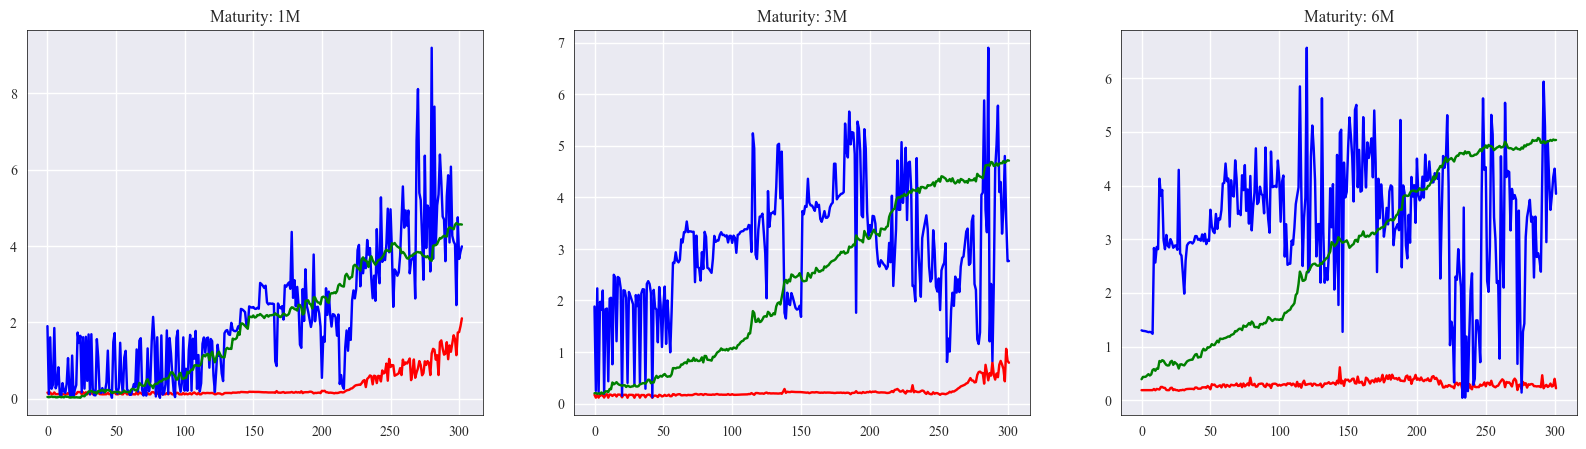

In [35]:

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

maturities = ['1M', '3M', '6M']
for i, maturity in enumerate(maturities):

    df = pd.read_csv(f'market_data/{maturity}_cleaned.csv')
    calib = pd.read_table(
        f"data/pointwise/pointwise_params_market_calibrated_dense_vasicek_{maturity}.dat", sep = " ", header = None
        )

    (100*calib.loc[:, 0] / calib.loc[:, 1]).plot(ax = ax[i], color = 'r');
    (100 * calib.loc[:, 3]).plot(ax = ax[i], color = 'b');
    ax[i].plot(df.Price.tolist(), color = 'g');
    ax[i].set_title(f'Maturity: {maturity}')

In [14]:
calib

,0,1,2,3
0,0.015047,9.547739,0.115992,0.018995
1,0.010203,9.097383,0.100595,0.001195
2,0.015274,9.519921,0.113656,0.016052
3,0.010290,9.116105,0.100846,0.002587
4,0.010945,9.170285,0.102759,0.003622
...,...,...,...,...
298,0.057182,5.024359,0.169809,0.024505
299,0.086867,5.017646,0.164395,0.047520
300,0.087570,5.021099,0.163088,0.036611
301,0.095593,5.035373,0.167200,0.038509
